In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

### Box size vs importance

In [33]:
with open('./BoxDistributions/box-distribution-115-enet-int-explainable.001.txt', 'r') as file:
    box_data = eval(file.read())
box_data = [np.array(single_box_data) for single_box_data in box_data]

<a list of 8 Text major ticklabel objects>

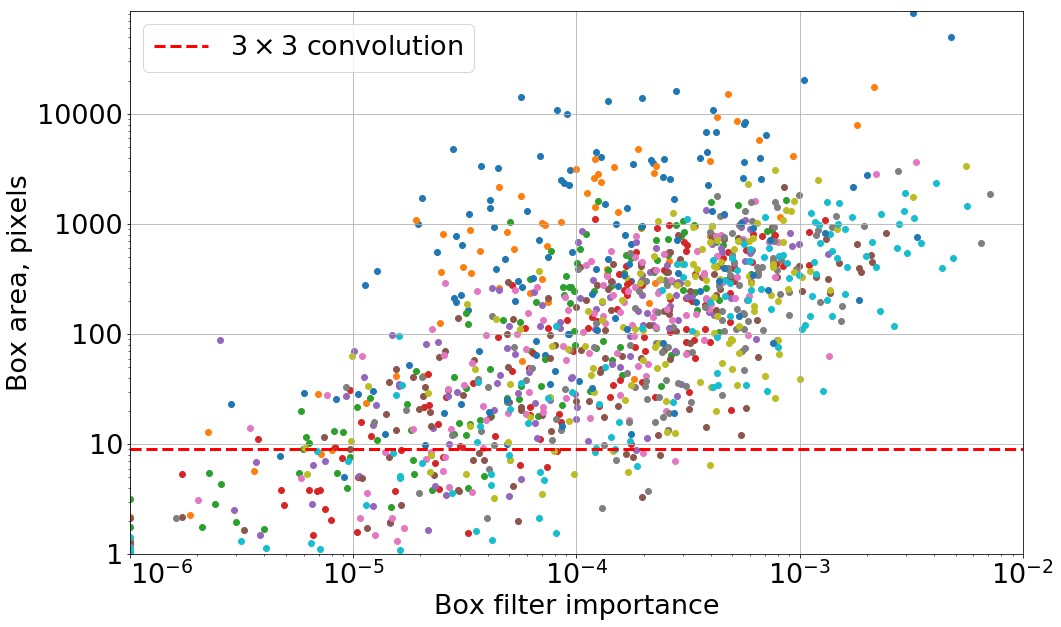

In [34]:
matplotlib.rcParams.update({'font.size': 27})

fig = plt.figure(figsize=(16,10))
ax = fig.gca()

left_limit = 1e-6

for single_box_data in box_data:
    single_box_data[:,0][single_box_data[:,0] < left_limit] = left_limit
    ax.scatter(single_box_data[:,0], single_box_data[:,1])

ax.set_ylim(1, ax.get_ylim()[1])
ax.set_xlim(left_limit, 1e-2)
nine = ax.plot(ax.get_xlim(), [9, 9], '--r', linewidth=3.0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
# ax.set_title('BoxENet filters learned at Cityscapes')
ax.set_xlabel('Box filter importance', )
ax.set_ylabel('Box area, pixels')
ax.legend(['$3 \\times 3$ convolution'])

from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.get_majorticklabels()[1].set_horizontalalignment('left')
ax.xaxis.get_majorticklabels()

# fig.savefig('BoxDistributions/box-size-distributions.pdf', bbox_inches='tight')

### Receptive field size

In [82]:
with open('ReceptiveFieldSize/00b-115-000-yer-10pts/data.txt', 'r') as file:
    model_names, receptive_field_data = eval(file.read())

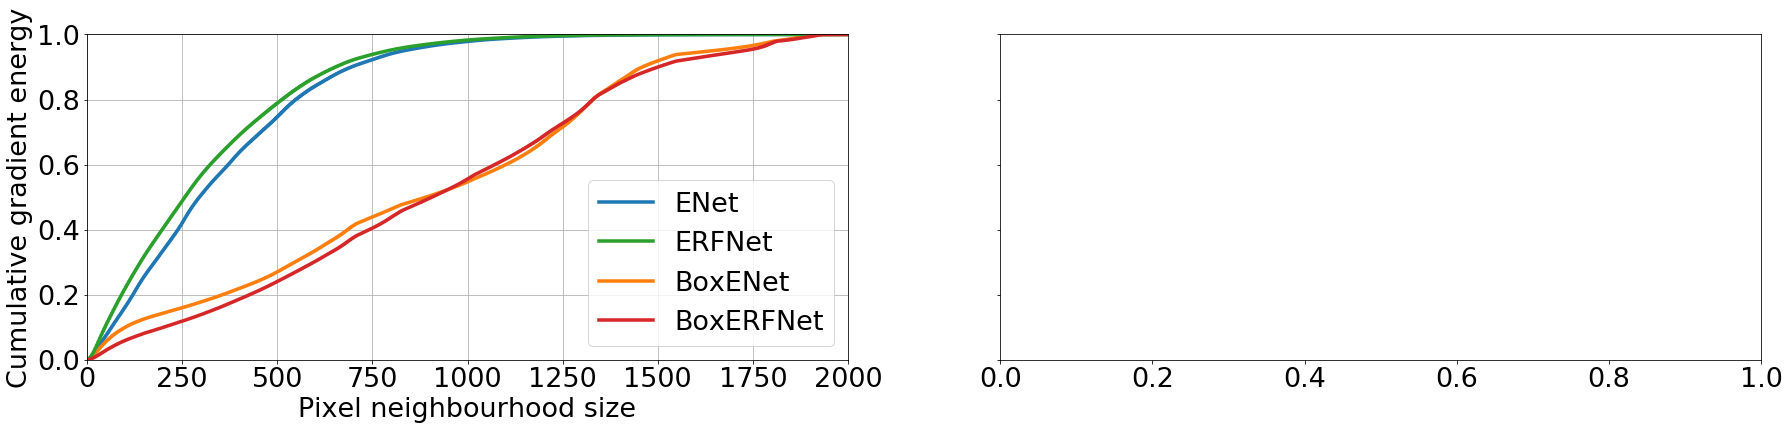

In [83]:
matplotlib.rcParams.update({'font.size': 27})

fig = plt.figure(figsize=(30,6))
ax1, ax2 = fig.subplots(1, 2, sharey=True)
ax = ax1
# fig = plt.figure(figsize=(16,6))
# ax = fig.gca()

max_window_size = 2000
line_artists = ax.plot(np.array(receptive_field_data).T[:max_window_size], linewidth=3.5)

ax.set_ylim(0, 1.0025)
ax.set_xlim(0, max_window_size)

ax.grid()

ax.set_xlabel('Pixel neighbourhood size')
ax.set_ylabel('Cumulative gradient energy')

line_artists[1], line_artists[2] = line_artists[2], line_artists[1]
from copy import copy
labels = copy(model_names)
labels[1], labels[2] = labels[2], labels[1]
legend = ax.legend(line_artists, labels, markerfirst=True)

fig.savefig('BoxDistributions/cumulative-gradient-energy.pdf', bbox_inches='tight')

In [84]:
with open('ReceptiveFieldSize/00b-115-20ptsrandom-upTo7/data.txt', 'r') as file:
    model_names, receptive_field_data = eval(file.read())

In [85]:
matplotlib.rcParams.update({'font.size': 27})

# fig = plt.figure(figsize=(16,6))
ax = ax2 #fig.gca()

max_window_size = 2000
line_artists = ax.plot(np.array(receptive_field_data).T[:max_window_size], linewidth=3.5)

ax.set_ylim(0, 1.006)
ax.set_xlim(0, max_window_size)

ax.grid()

ax.set_xlabel('Pixel neighbourhood size')
# ax.set_ylabel('Cumulative gradient energy')

# line_artists[1], line_artists[2] = line_artists[2], line_artists[1]
from copy import copy
labels = copy(model_names)
# labels[1], labels[2] = labels[2], labels[1]
legend = ax.legend(line_artists, labels, markerfirst=True, loc='lower right')

plt.tight_layout()

fig.savefig('BoxDistributions/cumulative-gradient-energy-both.pdf', bbox_inches='tight')

The effect of box filters on the receptive field of the model. The data were collected ... The gradient values are distributed less uniformly for base models, being grouped closer to the target point.

### Box evolution

In [2]:
import lutorpy as lua
require('torch')

<Lua table at 0x404bdba0>

In [5]:
model_name = '115-enet-int-explainable.001'

In [ ]:
# Load importances
with open('BoxDistributions/box-distribution-' + model_name + '.txt', 'r') as file:
    box_data = eval(file.read())
importances = [np.array(single_box_data)[:,0] for single_box_data in box_data]

In [94]:
# Load box evolution history
wDebs = []
for k,_ in enumerate(box_data, 1):
    wDeb = torch.load('../sshfs/Cityscapes segmentation/%s/wd%d.t7' % (model_name.replace('.', '/'), k))
    param_names = 'xMin', 'xMax', 'yMin', 'yMax'
    wDebs.append({name: np.array(wDeb[name])[:wDeb.size] for name in param_names})

In [95]:
# outputs two NUM_BOXESx5 arrays to feed into `plot()` for drawing rectangles
def wDeb_to_plot_data(wDeb, idx):
    xMin = wDeb['xMin'][idx]
    xMax = wDeb['xMax'][idx]
    yMin = wDeb['yMin'][idx]
    yMax = wDeb['yMax'][idx]
    
    retval_x = np.vstack((yMin, yMin, yMax, yMax, yMin)).T
    retval_y = np.vstack((xMin, xMax, xMax, xMin, xMin)).T
    return retval_x, retval_y

In [96]:
# BoxENet, 115
downsampling = [4,4,8,8,8,8,8,8,8,8,4,2]

Importance-aware plot

Text(0,0.5,'$y_{\\min}$, $y_{\\max}$')

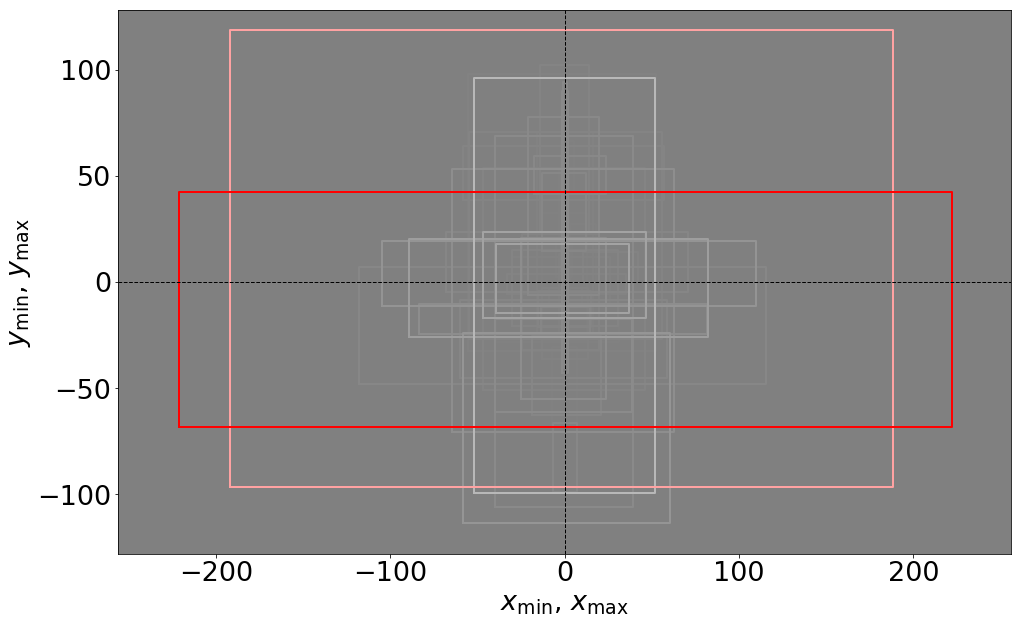

In [91]:
matplotlib.rcParams.update({'font.size': 27})

fig = plt.figure(figsize=(16,10))
ax = fig.gca()
ax.set_facecolor('gray')#[0.5] * 3 + [1.0])

int_idx, sample_idx = 0, -1

ax.set_xlim(np.array([-1024, 1024]) / downsampling[int_idx])
ax.set_ylim(np.array([- 512,  512]) / downsampling[int_idx])

x, y = wDeb_to_plot_data(wDebs[int_idx], sample_idx)
sorted_idx = np.argsort(importances[int_idx])
x, y = x[sorted_idx,:].T, y[sorted_idx,:].T
lines = ax.plot(x, y, linewidth=2.0);

xlim, ylim = ax.get_xlim(), ax.get_ylim()

horizontal_axis = ax.plot(xlim, [0, 0], '--', c='black', linewidth=1.0)
vertical_axis = ax.plot([0, 0], ylim, '--', c='black', linewidth=1.0)

colors = importances[int_idx].copy()[sorted_idx]
colors -= colors.min()
# colors = matplotlib.cm.RdGy_r(colors / colors.max()) #* [1., 0, 0, 1.]
colors = matplotlib.colors.LinearSegmentedColormap.from_list("", ['gray', 'white', 'red'])(colors / colors.max())
for line, color in zip(lines, colors):
    line.set_color(color)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

ax.set_xlabel('$x_{\min}$, $x_{\max}$')
ax.set_ylabel('$y_{\min}$, $y_{\max}$')

# ax.set_title('BoxENet filters learned at Cityscapes')

# fig.savefig('BoxDistributions/box-size-distributions.pdf', bbox_inches='tight')

Simple evolution plot

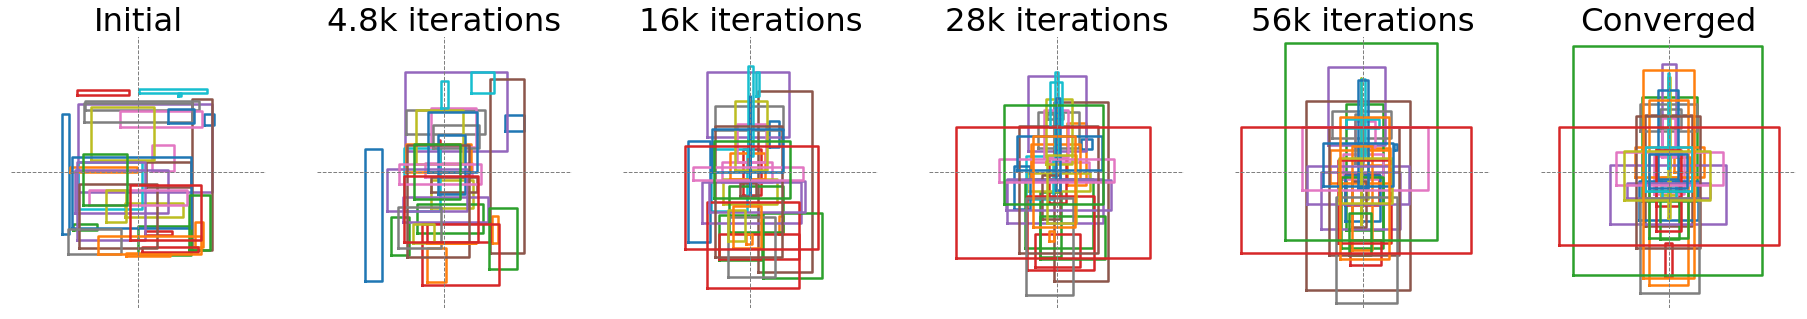

In [191]:
matplotlib.rcParams.update({'font.size': 27})

fig = plt.figure(figsize=(32,5))
ax_array = fig.subplots(1, 6, sharey=True, squeeze=True)

int_idx = 0
sample_idxes = [0, 12, 40, 70, 140, 962]

for ax, sample_idx in zip(ax_array, sample_idxes):
    xlim = np.array([-1024, 1024]) / downsampling[int_idx]
    ylim = np.array([- 512,  512]) / downsampling[int_idx]
    
    most_important = np.argsort(importances[int_idx])[30:]
    x, y = wDeb_to_plot_data(wDebs[int_idx], sample_idx)
    x, y = x[most_important], y[most_important]
    start_from, every_k = 0, 1
    lines = ax.plot(x[start_from::every_k].T, y[start_from::every_k].T, linewidth=2.5);

    horizontal_axis = ax.plot(xlim, [0, 0], '--', c='gray', linewidth=1.0)
    vertical_axis = ax.plot([0, 0], ylim, '--', c='gray', linewidth=1.0)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,
        labelleft=False,
        labelbottom=False)

    # ax.set_xlabel('$x_{\min}$, $x_{\max}$')
    # ax.set_ylabel('$y_{\min}$, $y_{\max}$')

    if sample_idx == 0:
        ax.set_title('Initial')
    elif sample_idx == wDebs[int_idx]['xMin'].shape[0]-1:
        ax.set_title('Converged')
    else:
        ax.set_title('%.2gk iterations' % ((sample_idx * 400) / 1000))
        
    ax.axis('off')

fig.savefig('BoxDistributions/box-evolution.pdf', bbox_inches='tight')

### Compute the symmetry score

In [2]:
import lutorpy as lua
require('torch')

<Lua table at 0x4039bba0>

In [76]:
model_name = '115-enet-int-explainable.004-noflip'

In [80]:
# Load box coordinates
import itertools

wDebs = []
for k in itertools.count(1):
    try:
        wDeb = torch.load('../sshfs/Projects/integral-layer/Cityscapes segmentation/%s/wd%d.t7' \
                          % (model_name.replace('.', '/'), k))
    except lua.LuaError:
        break
    param_names = 'xMin', 'xMax', 'yMin', 'yMax' #wDeb.size-1
    wDebs.append({name: np.array(wDeb[name])[0] for name in param_names})
    
assert wDebs, 'No files read'

In [65]:
def symm_score_iou(box):
    xMin, xMax, yMin, yMax = box
    xMin -= 0.5
    xMax += 0.5
    yMin -= 0.5
    yMax += 0.5
    if (xMax - xMin) * (yMax - yMin) < 14:
        return -1
    if yMin*yMax > 0:
        return 0
    if yMax > -yMin:
        return -yMin / yMax
    else:
        return yMax / -yMin

0.946121238031


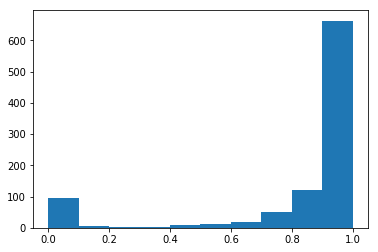

In [75]:
plt.hist(symm_scores)
print(0.946121238031)

0.560684612914


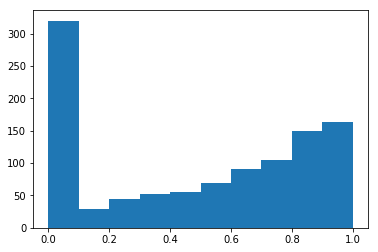

In [79]:
plt.hist(symm_scores)
print(0.560684612914)

0


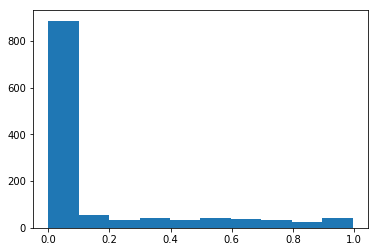

In [82]:
plt.hist(symm_scores)
print(0)

In [81]:
all_boxes = itertools.chain.from_iterable( \
    zip(*(wDeb[param] for param in ('xMin', 'xMax', 'yMin', 'yMax'))) for wDeb in wDebs)

symm_scores = np.fromiter(filter(lambda x: x >= 0, map(symm_score_iou, all_boxes)), dtype=np.float64)
print('Median symm score: ', np.median(symm_scores))

Median symm score:  0.0


### Pictures in a grid

In [10]:
from scipy import misc
a = 

/home/shrubb/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


/home/shrubb/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


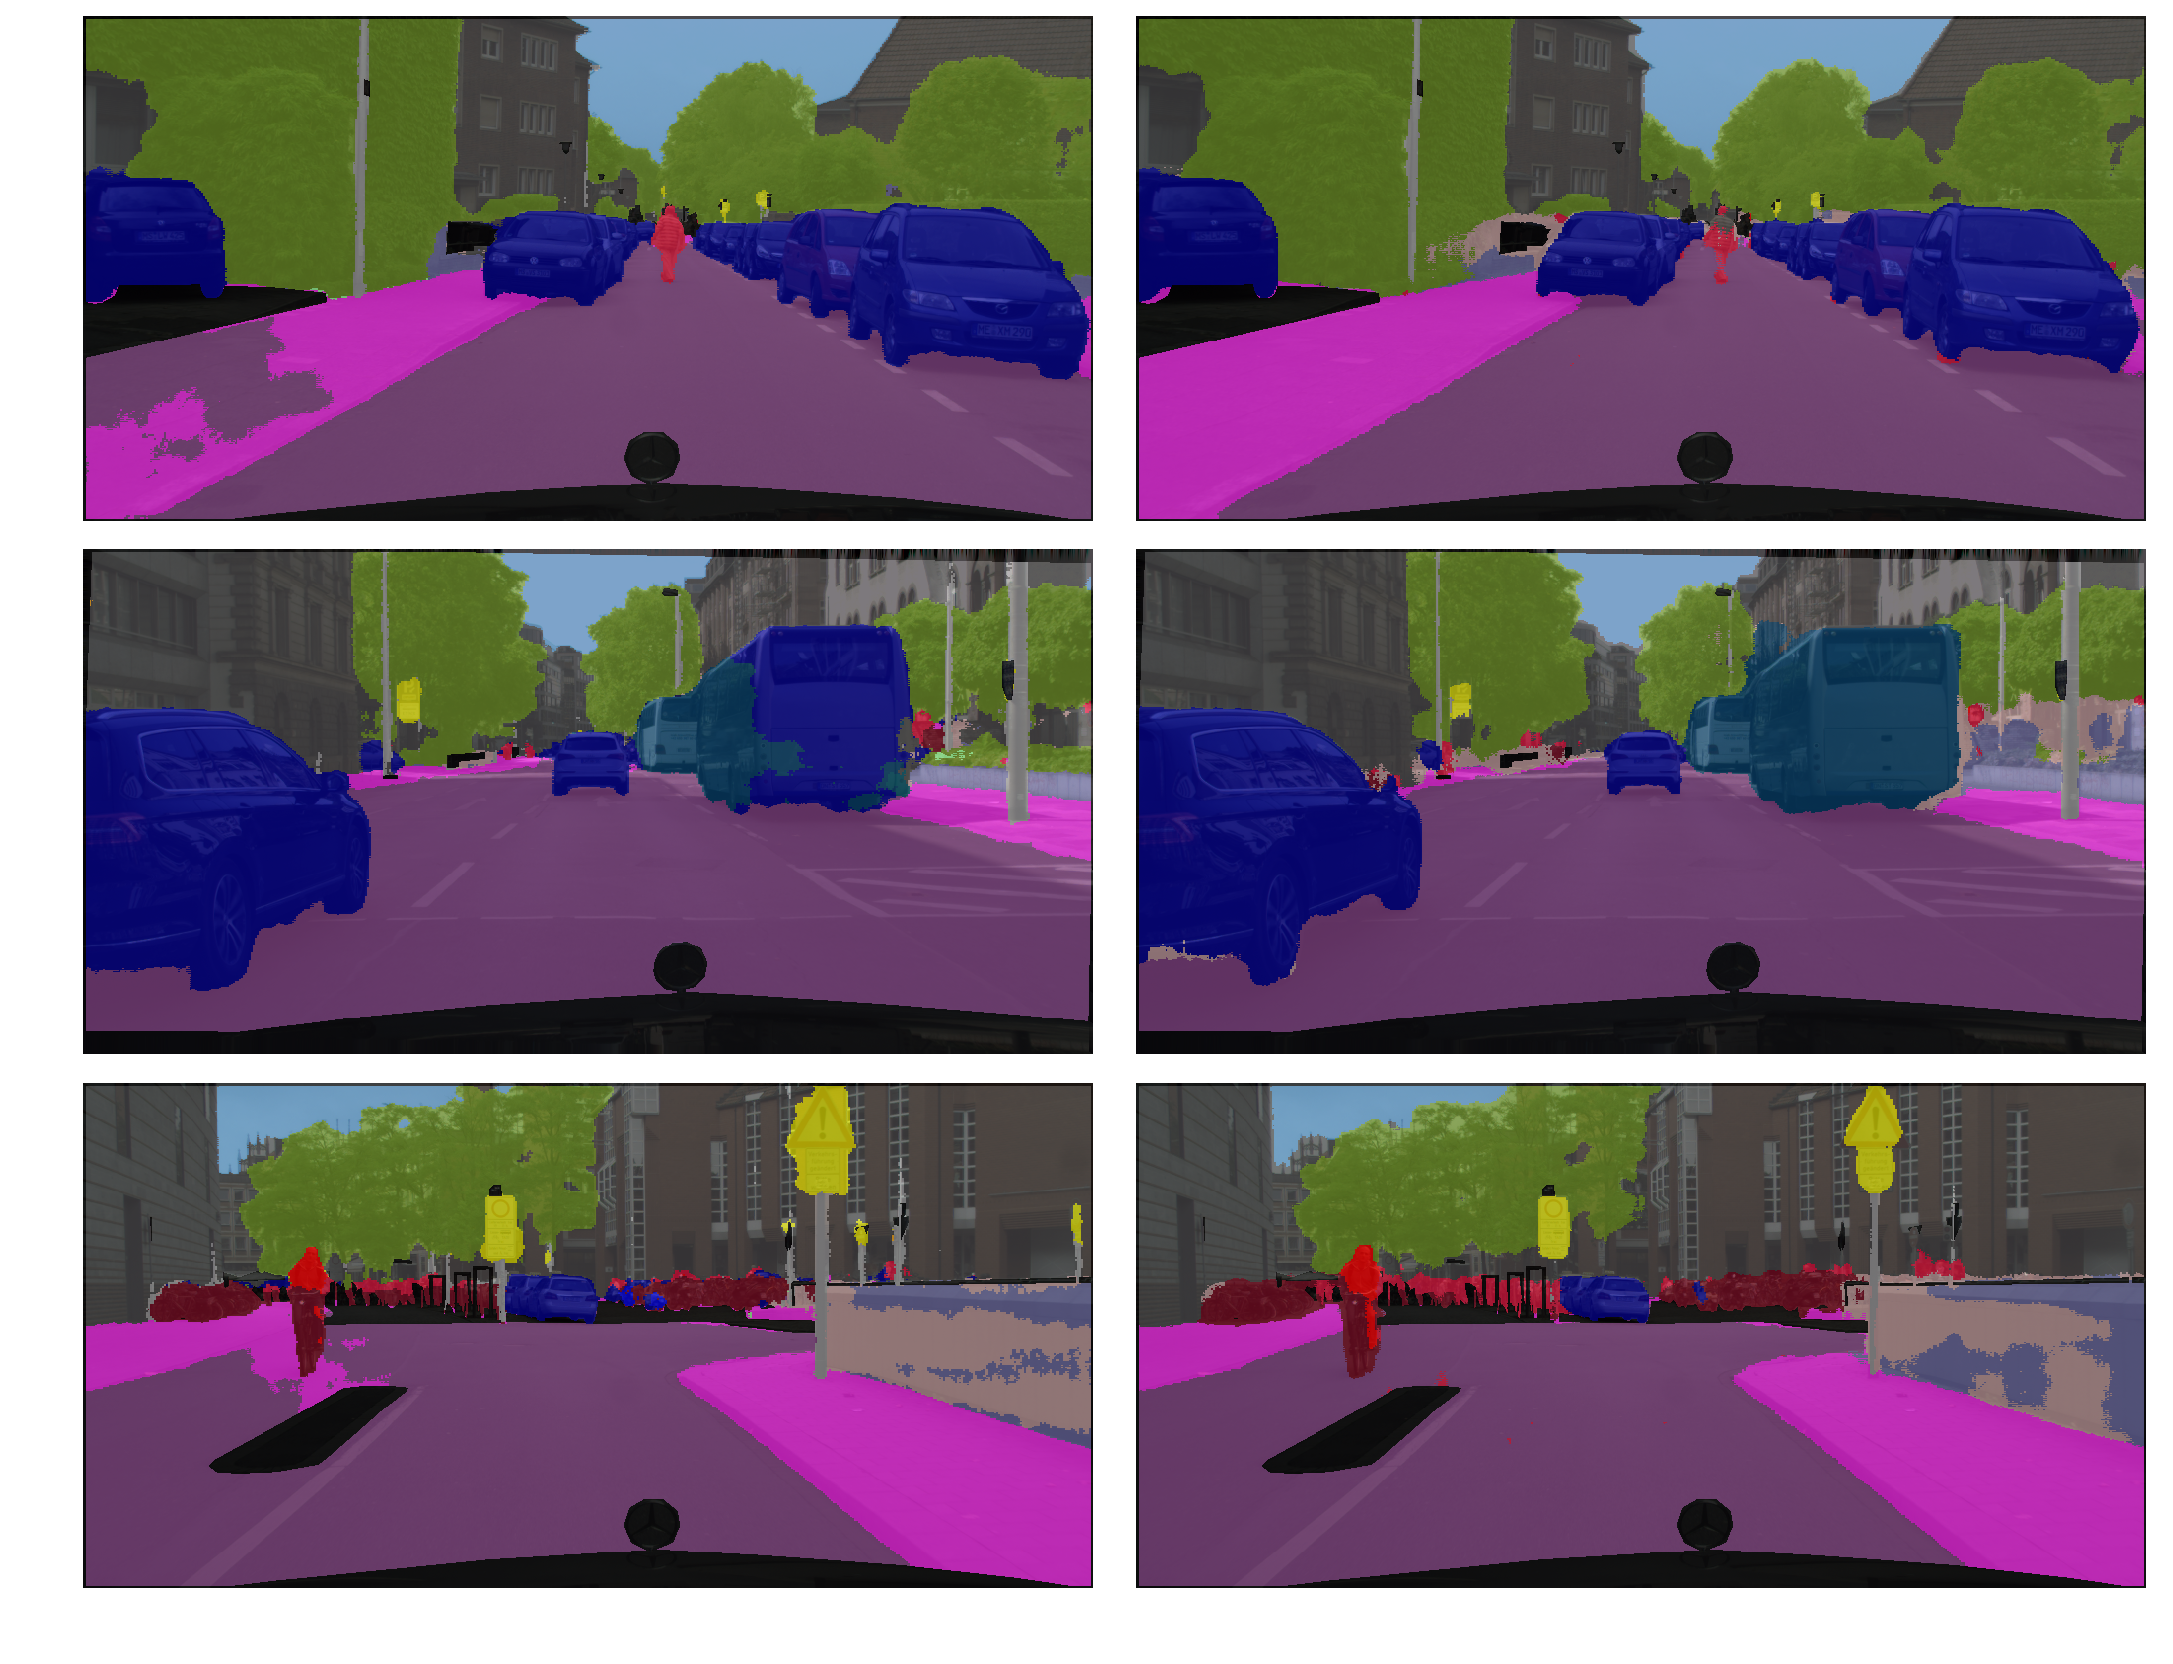

In [31]:
matplotlib.rcParams.update({'font.size': 27})

fig = plt.figure(figsize=(30,23))
ax_array = fig.subplots(3, 2, sharey=True, sharex=True).ravel()

image_files = 'enet09', 'boxenet09', 'enet10', 'boxenet10', 'enet18', 'boxenet18'

for image_file, ax in zip(image_files, ax_array):
    img = misc.imread('DifferentResults/' + image_file + '.png')
    ax.imshow(img)
    
    ax.tick_params(
        axis='none',       # changes apply to the x-axis
        which='none',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,
        labelleft=False,
        labelbottom=False)

    ax.axis('off')

ax_array[-2].set_xlabel('ENet')
ax_array[-1].set_xlabel('BoxENet')

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.savefig('DifferentResults/scene-parsing-comparison.pdf', bbox_inches='tight')